In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")


In [9]:
#--- 1. Data Loading and Initial Cleaning ---

file_path = '1730285881-Airbnb_Open_Data.xlsx'
try:
    df = pd.read_excel(file_path)
    print(f"Data loaded successfully. Initial rows: {len(df)}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please upload it to your Colab environment.")
    exit()

Data loaded successfully. Initial rows: 102599


In [10]:
df.drop_duplicates(inplace=True)

def clean_currency_and_convert(series):
    if series.dtype == object:
        series = series.astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False)
    return pd.to_numeric(series, errors='coerce')

df['price'] = clean_currency_and_convert(df['price'])
df['service fee'] = clean_currency_and_convert(df['service fee'])

df['minimum nights'] = pd.to_numeric(df['minimum nights'], errors='coerce').fillna(0).astype(int)
df['number of reviews'] = pd.to_numeric(df['number of reviews'], errors='coerce').fillna(0).astype(int)
df['host name'].fillna('Unknown Host', inplace=True)

# Critical columns for analysis (using corrected names: lat, long)
critical_cols = ['price', 'service fee', 'neighbourhood group', 'room type', 'lat', 'long', 'cancellation_policy', 'host name', 'instant_bookable']
df.dropna(subset=critical_cols, inplace=True)

df['Total Cost'] = df['price'] + df['service fee']


/tmp/ipython-input-899551353.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host name'].fillna('Unknown Host', inplace=True)


In [13]:
# --- 2. Outlier Handling ---

def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

df = cap_outliers_iqr(df, 'Total Cost')
df['price'] = df['Total Cost'] - df['service fee']
print(f"Data cleaning complete. Final rows for analysis: {len(df)}")


Data cleaning complete. Final rows for analysis: 101441


In [14]:
# Q1: What is the overall average price of a listing?
avg_price = df['price'].mean()
print(f"Q1: Average Price: ${avg_price:,.2f}")


Q1: Average Price: $625.25


In [15]:
# Q2: What is the average Total Cost (Price + Service Fee) of a listing?
avg_total_cost = df['Total Cost'].mean()
print(f"Q2: Average Total Cost: ${avg_total_cost:,.2f}")

Q2: Average Total Cost: $750.30


In [16]:
# Q3: Which Neighbourhood Group has the highest average Total Cost?
highest_cost_group = df.groupby('neighbourhood group')['Total Cost'].mean().idxmax()
print(f"Q3: Highest Cost Neighbourhood Group: {highest_cost_group}")


Q3: Highest Cost Neighbourhood Group: Queens


In [17]:
# Q4: Which Room Type is the most common?
most_common_room_type = df['room type'].mode()[0]
print(f"Q4: Most Common Room Type: {most_common_room_type}")


Q4: Most Common Room Type: Entire home/apt


In [18]:
# Q5: Who are the Top 5 Hosts by the number of listings they manage?
top_5_hosts = df['host name'].value_counts().nlargest(5)
print("\nQ5: Top 5 Hosts by Listing Count:\n", top_5_hosts)



Q5: Top 5 Hosts by Listing Count:
 host name
Michael         870
David           758
John            572
Alex            542
Sonder (NYC)    516
Name: count, dtype: int64


In [19]:
# Q6: What is the average Minimum Nights stay required?
avg_min_nights = df['minimum nights'].mean()
print(f"Q6: Average Minimum Nights Stay: {avg_min_nights:.2f} nights")

Q6: Average Minimum Nights Stay: 8.07 nights


In [20]:
# Q7: How many listings are instant bookable?
instant_bookable_counts = df['instant_bookable'].value_counts()
print("\nQ7: Instant Bookable Counts:\n", instant_bookable_counts)


Q7: Instant Bookable Counts:
 instant_bookable
0.0    50930
1.0    50511
Name: count, dtype: int64


In [21]:
# Q8: What is the correlation between the number of reviews and the listing price?
price_reviews_corr = df['price'].corr(df['number of reviews'])
print(f"Q8: Correlation (Price vs. Reviews): {price_reviews_corr:.4f}")


Q8: Correlation (Price vs. Reviews): 0.0051


In [22]:
# Q9: What is the distribution of listings based on Cancellation Policy?
cancellation_policy_dist = df['cancellation_policy'].value_counts()
print("\nQ9: Cancellation Policy Distribution:\n", cancellation_policy_dist)



Q9: Cancellation Policy Distribution:
 cancellation_policy
moderate    33981
strict      33756
flexible    33704
Name: count, dtype: int64


/tmp/ipython-input-50756245.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='room type', data=df, palette='magma', order=df['room type'].value_counts().index)


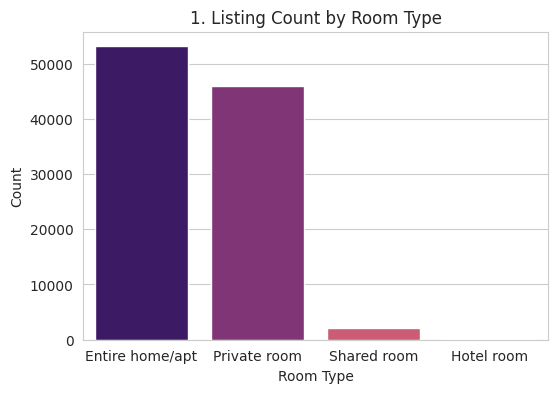

In [23]:
# Chart 1: Listing Count by Room Type (Bar Plot)
plt.figure(figsize=(6, 4))
sns.countplot(x='room type', data=df, palette='magma', order=df['room type'].value_counts().index)
plt.title('1. Listing Count by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

/tmp/ipython-input-1224976029.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='neighbourhood group', y='Total Cost', data=df, palette='viridis')


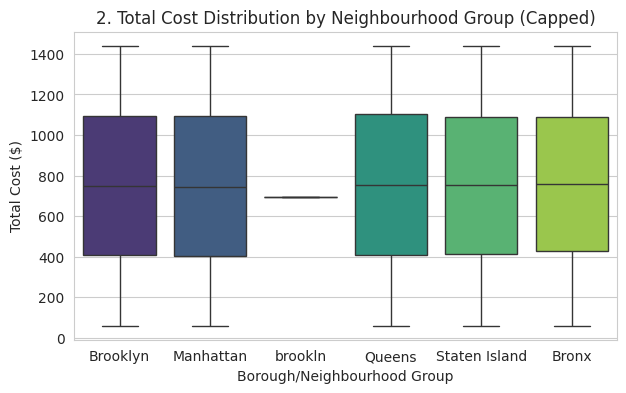

In [24]:
# Chart 2: Total Cost Distribution by Neighbourhood Group (Box Plot)
plt.figure(figsize=(7, 4))
sns.boxplot(x='neighbourhood group', y='Total Cost', data=df, palette='viridis')
plt.title('2. Total Cost Distribution by Neighbourhood Group (Capped)')
plt.xlabel('Borough/Neighbourhood Group')
plt.ylabel('Total Cost ($)')
plt.show()


/tmp/ipython-input-166490416.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='cancellation_policy', y='Total Cost', data=df, palette='Set2', inner='quartile')


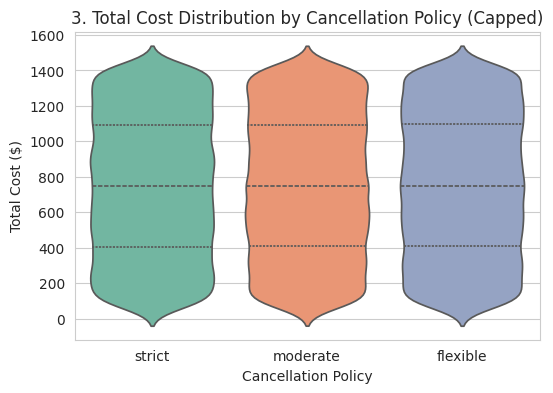

In [25]:
# Chart 3: Price Distribution by Cancellation Policy (Violin Plot)
plt.figure(figsize=(6, 4))
sns.violinplot(x='cancellation_policy', y='Total Cost', data=df, palette='Set2', inner='quartile')
plt.title('3. Total Cost Distribution by Cancellation Policy (Capped)')
plt.xlabel('Cancellation Policy')
plt.ylabel('Total Cost ($)')
plt.show()


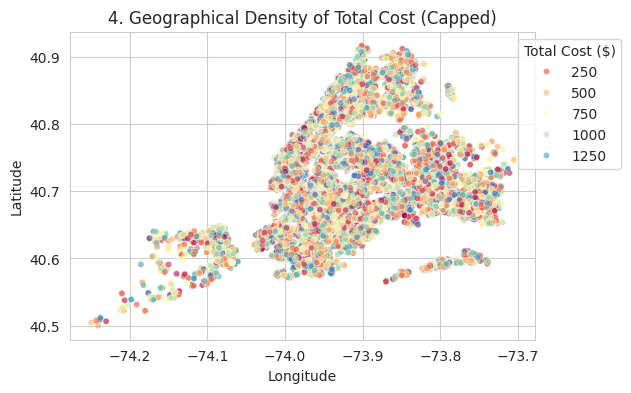

In [26]:
# Chart 4: Geographical Density (Total Cost vs. Location) - Scatter Plot
plt.figure(figsize=(6, 4))
sns.scatterplot(
    x='long',
    y='lat',
    data=df,
    hue='Total Cost',
    palette='Spectral',
    alpha=0.6,
    s=20
)
plt.title('4. Geographical Density of Total Cost (Capped)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Total Cost ($)', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


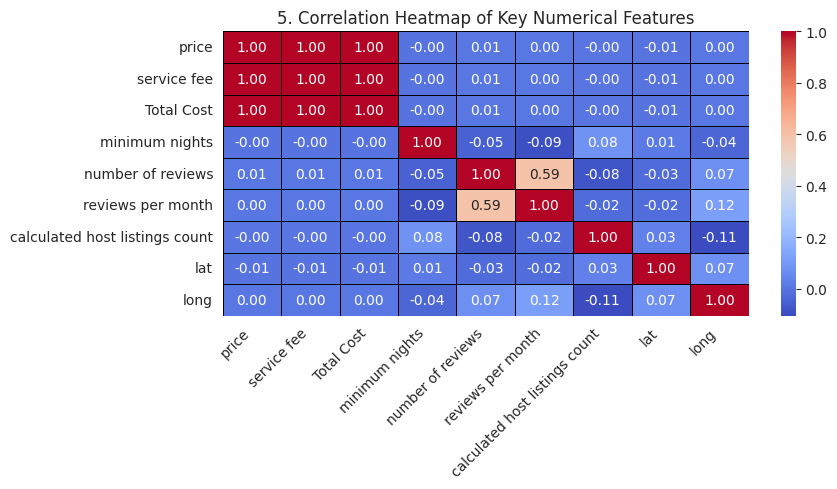

In [27]:
# Chart 5: Correlation Heatmap
corr_cols = ['price', 'service fee', 'Total Cost', 'minimum nights','number of reviews', 'reviews per month', 'calculated host listings count','lat', 'long']
plt.figure(figsize=(9, 5))
correlation_matrix = df[corr_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, linecolor='black')
plt.title('5. Correlation Heatmap of Key Numerical Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()